# how many systems are unbound by SN1 vs SN2 at higher Z? 

also

# What is the core mass of the potential DCO progenitors at different metallicity? 



In [1]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec
import traceback


home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02"# "v02.46.01/"#v02.35.02/"
sim_name =  'NewWinds_RemFryer2012' #'OldWinds_RemFryer2012'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  
channel_key     = '_CE' #'', '_stable' # '_CE' '_CHE'  '' 

datar_root = f"{home_dir}/ceph/CompasOutput/{compas_v}"

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



In [2]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = f'potential_DCO_progenitors_Allinfo{channel_key}.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(f'{datar_root}/{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)
    

### Split your table between merging BBH/BHNS/NSNS
potential_BBH_progenitors  = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHBH_bool']]
potential_BHNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_BHNS_bool']]
potential_NSNS_progenitors = potential_DCO_progenitors[potential_DCO_progenitors['pot_NSNS_bool']]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 193392 entries, 0 to 193391
Columns: 116 entries, SEED to pot_NSNS_bool
dtypes: bool(3), float64(100), int32(2), object(3), uint32(1), uint64(1), uint8(6)
memory usage: 158.8+ MB
Table exists, reading in...  None


In [3]:
sum(potential_BBH_progenitors['Metallicity@ZAMS(1)']== 0.01414214)

3207

## Plot the number of SN1 unbound per Z

In [4]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

print(list(potential_BBH_progenitors.columns) )


print(np.unique(potential_BBH_progenitors['SN_star2_Supernova_State']))
# print(np.unique(potential_BBH_progenitors['SN_star1_Unbound']))
# print(np.unique(potential_BBH_progenitors['SN_star2_Unbound']))

print(len(np.where(potential_BBH_progenitors['SN_star2_Supernova_State'].isna())[0] )  )

metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]
['SEED', 'Metallicity@ZAMS(1)', 'Stellar_Type(1)', 'Stellar_Type(2)', 'CE_Event_Counter', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'SemiMajorAxis@ZAMS', 'Merger', 'Merger_At_Birth', 'Unbound', 'Immediate_RLOF>CE', 'Optimistic_CE', 'Applied_Kick_Magnitude(1)', 'Applied_Kick_Magnitude(2)', 'CH_on_MS(1)', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Phi(1)', 'SN_Kick_Theta(1)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(2)', 'SN_Kick_Mean_Anomaly(2)', 'Merges_Hubble_Time', 'SemiMajorAxis@DCO', 'Coalescence_Time', 'Eccentricity@DCO', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'unique_Z_SEED', 'firstMT_SemiMajorAxis<MT', 'firstMT_SemiMajorAxis>MT', 'firstMT_Radius(1)<MT', 'firstMT_Radius(2)<MT', 'firstMT_Radius(1)>MT', 'firstMT_Radius(2)>MT', 'firstMT_Mass(1)<MT', 'firstMT_Mass(2)<MT

SUPERNOVA_STATE

Indicates which star(s) went supernova. Will be printed as one of:

    No supernova = 0
    Star 1 is the supernova  = 1
    Star 2 is the supernova = 2
    Both stars are supernova = 3

In [5]:
def get_unbound(table = potential_DCO_progenitors):

    """
    Count the number of systems that are unbound by SN 1
    Args:
    table: pandas dataframe of potential DCO progenitors

    Returns:
    N_unbound_by_SN1, N_unbound_by_SN2
    """
    table['SN_star1_should_be_unbound1'] = table['SN_star1_Applied_Kick_Magnitude(SN)'] > table['SN_star1_Orb_Velocity<SN']
    table['SN_star2_should_be_unbound1'] = table['SN_star2_Applied_Kick_Magnitude(SN)'] > table['SN_star2_Orb_Velocity<SN']

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size() # total number in this table (per Z)

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())

    # unbound by SN1
    N_unbound_by_SN1  = grouped_byZ.apply(lambda x: ( (x['SN_star1_Supernova_State']==1) & (x['SN_star2_Supernova_State'].isna()) & (x['Unbound']==1) ).sum())
    # Select information for first SN
    # N_unbound_by_SN1  = grouped_byZ.apply(lambda x: ((x['SN_star1_Supernova_State']==1) & (x['SN_star1_Unbound']==1) ).sum())

    # unbound by SN2
    N_unbound_by_SN2  = grouped_byZ.apply(lambda x: ((x['SN_star1_Supernova_State']==1) & (x['SN_star2_Supernova_State']==2) &  (x['Unbound']==1) ).sum())
    # Select information for second SN
    # N_unbound_by_SN2  = grouped_byZ.apply(lambda x: ((x['SN_star2_Supernova_State']==2) & (x['SN_star2_Unbound']==1)  & (x['SN_star1_Unbound']==0) ).sum())

    # unbound by SN2, but there was no SN1? 
    N_unbound_by_SN2_noSN1  = grouped_byZ.apply(lambda x: ((x['SN_star1_Supernova_State'].isna() ) & (x['SN_star2_Supernova_State']==2) &  (x['Unbound']==1) ).sum())

    return N_tot_DCO_prog, N_unbound, N_unbound_by_SN1, N_unbound_by_SN2, N_unbound_by_SN2_noSN1


/tmp/ipykernel_469930/2778478650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['SN_star1_should_be_unbound1'] = table['SN_star1_Applied_Kick_Magnitude(SN)'] > table['SN_star1_Orb_Velocity<SN']
/tmp/ipykernel_469930/2778478650.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['SN_star2_should_be_unbound1'] = table['SN_star2_Applied_Kick_Magnitude(SN)'] > table['SN_star2_Orb_Velocity<SN']
/tmp/ipykernel_469930/2778478650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a co

N_tot_DCO_prog Metallicity@ZAMS(1)
0.000100    3207
0.000173    3207
0.000300    3207
0.000548    3207
0.001000    3207
0.002000    3207
0.004000    3207
0.006325    3207
0.010000    3207
0.014142    3207
0.020000    3207
0.030000    3207
dtype: int64
N_tot_DCO_prog Metallicity@ZAMS(1)
0.000100    2093
0.000173    2093
0.000300    2093
0.000548    2093
0.001000    2093
0.002000    2093
0.004000    2093
0.006325    2093
0.010000    2093
0.014142    2093
0.020000    2093
0.030000    2093
dtype: int64
N_tot_DCO_prog Metallicity@ZAMS(1)
0.000100    5677
0.000173    5677
0.000300    5677
0.000548    5677
0.001000    5677
0.002000    5677
0.004000    5677
0.006325    5677
0.010000    5677
0.014142    5677
0.020000    5677
0.030000    5677
dtype: int64


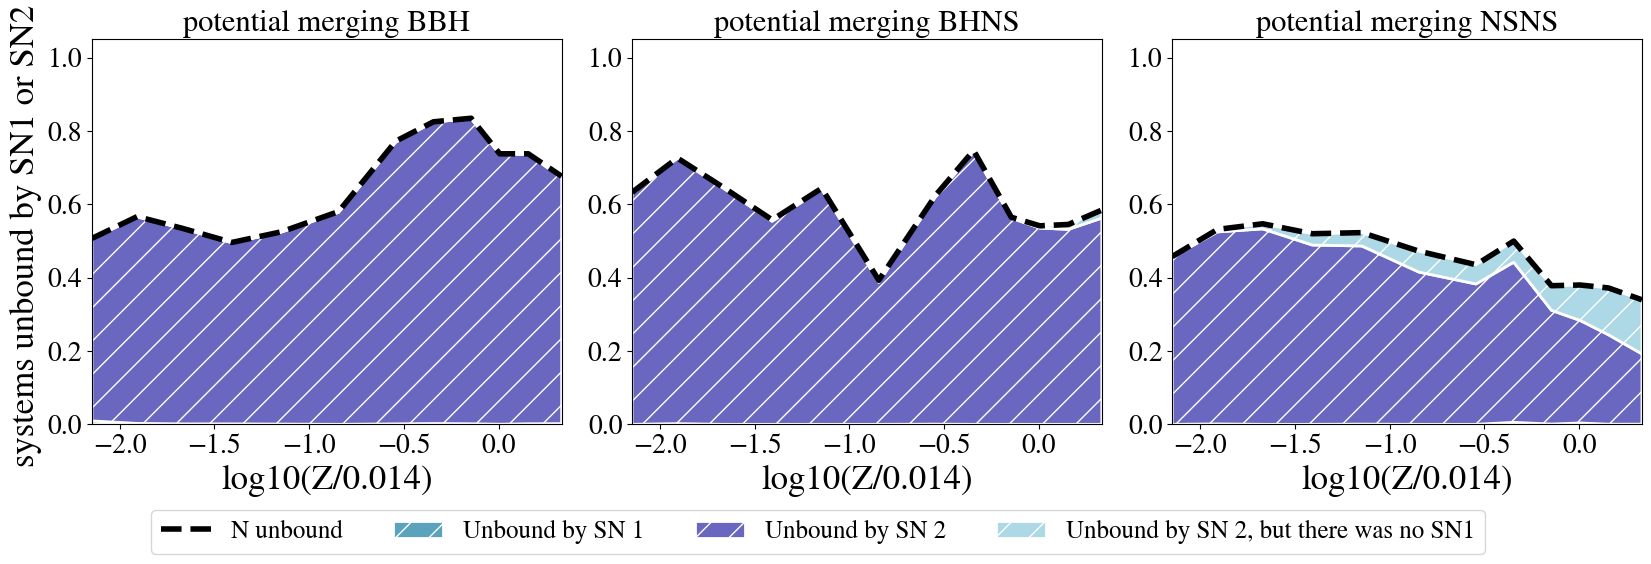

In [6]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
# print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

# first_or_second_mt = 'star2_firstMT_' #'firstMT_' # 'star2_firstMT_' # 

###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# List of panda tables of pot DCO progenitors
titles = ["BBH", "BHNS", "NSNS"]
dfs = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and dataframes
for ax, df, title in zip(axes, dfs, titles):
    ax.plot(1,1)
    N_tot_DCO_prog, N_unbound, N_unbound_by_SN1, N_unbound_by_SN2, N_unbound_by_SN2_noSN1 =  get_unbound(table = df)
    print('N_tot_DCO_prog', N_tot_DCO_prog)

    
    # Normalize or abs numbers?
    norm = N_tot_DCO_prog #N_unbound # 1. # N_tot_DCO_prog

    try:
        ax.plot(Z_Zsun, N_unbound/norm, color='k', label='N unbound', ls = '--', lw = 4,alpha = 1)

    except Exception as e:
        print('no systems for this flavor & channel')
        print('Error:', e)
        traceback.print_exc()
        continue

    bottom = np.zeros(len(Z_Zsun))

    # Unbound by SN1
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound_by_SN1)/norm, color='#5ba3bd', edgecolor='white', hatch='/', lw = 2, label='Unbound by SN 1', alpha = 1)
    bottom += N_unbound_by_SN1

    # Unbound by SN2
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound_by_SN2)/norm, color='#6967bf', edgecolor='white', hatch='/', lw = 2, label='Unbound by SN 2', alpha = 1)
    bottom += N_unbound_by_SN2

    # Unbound by SN2, but there was no SN1?
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound_by_SN2_noSN1)/norm, color='lightblue', edgecolor='white', hatch='/', lw = 2, label='Unbound by SN 2, but there was no SN1', alpha = 1)
    bottom += N_unbound_by_SN2_noSN1

    ax.set_title(f'potential merging {title}', fontsize = 22) #7x{N_tot_DCO_prog[0.0001]}
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,)
    ax.set_xlabel('log10(Z/0.014)', fontsize = 25)

#########################
# plotvalues
fig.subplots_adjust(wspace=0.15)

axes[0].set_ylabel("systems unbound by SN1 or SN2 ", fontsize = 25)

axes[0].legend(bbox_to_anchor=(0.1, -0.19), loc='upper left', fontsize = 18, ncols = 4)

# plt.savefig(f'../plots/{compas_v}/UnboundBySN12{sim_name}{channel_key}.pdf', bbox_inches='tight')
plt.show()



In [11]:
list(potential_BBH_progenitors.columns )

['SEED',
 'Metallicity@ZAMS(1)',
 'Stellar_Type(1)',
 'Stellar_Type(2)',
 'CE_Event_Counter',
 'Mass@ZAMS(1)',
 'Mass@ZAMS(2)',
 'SemiMajorAxis@ZAMS',
 'Merger',
 'Merger_At_Birth',
 'Unbound',
 'Immediate_RLOF>CE',
 'Optimistic_CE',
 'Applied_Kick_Magnitude(1)',
 'Applied_Kick_Magnitude(2)',
 'CH_on_MS(1)',
 'SN_Kick_Magnitude_Random_Number(1)',
 'SN_Kick_Phi(1)',
 'SN_Kick_Theta(1)',
 'SN_Kick_Mean_Anomaly(1)',
 'SN_Kick_Magnitude_Random_Number(2)',
 'SN_Kick_Phi(2)',
 'SN_Kick_Theta(2)',
 'SN_Kick_Mean_Anomaly(2)',
 'Merges_Hubble_Time',
 'SemiMajorAxis@DCO',
 'Coalescence_Time',
 'Eccentricity@DCO',
 'MT_Donor_Hist(1)',
 'MT_Donor_Hist(2)',
 'Mass(1)',
 'Mass(2)',
 'unique_Z_SEED',
 'firstMT_SemiMajorAxis<MT',
 'firstMT_SemiMajorAxis>MT',
 'firstMT_Radius(1)<MT',
 'firstMT_Radius(2)<MT',
 'firstMT_Radius(1)>MT',
 'firstMT_Radius(2)>MT',
 'firstMT_Mass(1)<MT',
 'firstMT_Mass(2)<MT',
 'firstMT_Mass(1)>MT',
 'firstMT_Mass(2)>MT',
 'firstMT_Stellar_Type(1)<MT',
 'firstMT_Stellar_Type(2

In [88]:
pot_BBH_grouped_byZ = potential_BBH_progenitors.groupby('Metallicity@ZAMS(1)')
# print(pot_BBH_grouped_byZ.groups.keys())

    plt.hist(group_table['SN_star2_Unbound'][group_table['Unbound'] == True],
     label = Z_group[0], bins = np.arange(0.5,16.5), color = colors[Z_i], histtype='step')


plt.xlabel('firstMT_Stellar_Type(1)<MT ')
plt.xticks(range(1,16))
plt.ylim(0,2600)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 15)
plt.show()




IndentationError: unexpected indent (3451947589.py, line 4)

In [41]:
pot_BBH_grouped_byZ = potential_BBH_progenitors.groupby('Metallicity@ZAMS(1)')
# print(pot_BBH_grouped_byZ.groups.keys())

import seaborn as sns
import matplotlib.cm as cm
cmap = cm.get_cmap('magma')  
color_values = np.linspace(0, 1, len(pot_BBH_grouped_byZ.groups))
colors = cmap(color_values)


# print(pot_BBH_grouped_byZ.get_group(0.0001))
for Z_i, Z_group in enumerate(pot_BBH_grouped_byZ):
    print(Z_group[0])
    group_table = Z_group[1]

    plt.hist(group_table['firstMT_Stellar_Type(1)<MT'][group_table['Unbound'] == True],
     label = Z_group[0], bins = np.arange(0.5,16.5), color = colors[Z_i], histtype='step')


plt.xlabel('firstMT_Stellar_Type(1)<MT ')
plt.xticks(range(1,16))
plt.ylim(0,2600)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 15)
plt.show()




array([nan, nan, nan, ..., nan, nan, nan], dtype=object)

In [38]:
unbound_pot_BBH_grouped_byZ = unbound_pot_BBH.groupby('Metallicity@ZAMS(1)')



# print(pot_BBH_grouped_byZ.get_group(0.0001))
for Z_group in unbound_pot_BBH_grouped_byZ:
    print(Z_group[0])
    group_table = Z_group[1]

['firstMT_Stellar_Type(1)<MT']


In [16]:

# Loop over all directories starting wiht "logZ"
print(f'reading from {datar_root}/{sim_name}/')
for i, dir in enumerate(os.listdir(datar_root+ f'/{sim_name}/')):

    if dir.startswith('logZ'):
        print(f"Reading DCO seeds from {dir}")

        # Open the HDF5 file for all systems at a given metallicity
        data = h5.File(f'{datar_root}/{sim_name}/{dir}/COMPAS_Output.h5', 'r')

        # How many systems are unbound by SN1 or SN2?
        # all_seeds   = data['BSE_System_Parameters']['SEED'][()]
        # print(len(all_seeds))
        len_all_seeds = 5000000
        # unbound     = data['BSE_System_Parameters']['Unbound'][()]

        # Select only the SN events for systems that could potentially become a DCO
        print(data['BSE_Supernovae'].keys())
        SN_seeds          = data['BSE_Supernovae']['SEED'][()]
        Supernova_State   = data['BSE_Supernovae']['Supernova_State'][()]
        Supernova_unbound = data['BSE_Supernovae']['Unbound'][()]

        Supernovastar_ZAMSmass = data['BSE_Supernovae']['Mass@ZAMS(SN)'][()]
        Companionstar_ZAMSmass = data['BSE_Supernovae']['Mass@ZAMS(CP)'][()]

        # # # # # # # # # # # # # # # # # # # # # # # # 
        # systems thatare unbound by SN1
        unbound_SN1 = np.logical_and(Supernova_State == 1, Supernova_unbound == 1)
        print(f"All: unbound by SN1: {np.sum(unbound_SN1)}, = {np.sum(unbound_SN1)/len_all_seeds*100:.2f}%")

        # DCO progenitor systems that are unbound by SN1
        DCO_prog_unboundSN1 = ( (Supernovastar_ZAMSmass >= 8) & (Companionstar_ZAMSmass >= 8) & unbound_SN1)
        print(f"DCO: unbound by SN1 and Mzams1, Mzams2 >8: {np.sum(DCO_prog_unboundSN1)}, = {np.sum(DCO_prog_unboundSN1)/len_all_seeds*100:.2f}%")

        # Unbound by SN1, but M1 and M2 ZAMS are >20 Msun
        BHBH_prog_unboundSN1 = ( (Supernovastar_ZAMSmass >= 20) & (Companionstar_ZAMSmass >= 20) & unbound_SN1)
        print(f"BHBH: unbound by SN1 and Mzams1, Mzams2 >20: {np.sum(BHBH_prog_unboundSN1)}, = {np.sum(BHBH_prog_unboundSN1)/len_all_seeds*100:.2f}%")

        # Unbound by SN1, but M1 and M2 ZAMS are >20 Msun
        NSNS_prog_unboundSN1 = ( (Supernovastar_ZAMSmass >= 8) & (Supernovastar_ZAMSmass < 20) & (Companionstar_ZAMSmass >= 8) & (Companionstar_ZAMSmass < 20) & unbound_SN1)
        print(f"NSNS: unbound by SN1 and Mzams1, Mzams2 [8,20]: {np.sum(NSNS_prog_unboundSN1)}, = {np.sum(NSNS_prog_unboundSN1)/len_all_seeds*100:.2f}%")

        # Unbound by SN1, but M1 and M2 ZAMS are >20 Msun
        BHNS_prog_unboundSN1 = ( (Supernovastar_ZAMSmass >= 20) & (Companionstar_ZAMSmass >= 8) & (Companionstar_ZAMSmass < 20) & unbound_SN1)
        print(f"BHNS: unbound by SN1 and Mzams1 >20, Mzams2 [8,20]: {np.sum(BHNS_prog_unboundSN1)}, = {np.sum(BHNS_prog_unboundSN1)/len_all_seeds*100:.2f}%")


        # # # # # # # # # # # # # # # # # # # # # # # # 
        # systems that are unbound by SN2
        unbound_SN2 = np.logical_and(Supernova_State == 2, Supernova_unbound == 1)
        print(f"unbound by SN2: {np.sum(unbound_SN2)}, = {np.sum(unbound_SN2)/len_all_seeds*100:.2f}%")

        # Unbound by SN1, but M1 and M2 ZAMS are >20 Msun
        BHBH_prog_unboundSN2 = ( (Supernovastar_ZAMSmass >= 20) & (Companionstar_ZAMSmass >= 20) & unbound_SN2)
        print(f"unbound by SN2 and Mzams1, Mzams2 >20: {np.sum(BHBH_prog_unboundSN2)}, = {np.sum(BHBH_prog_unboundSN2)/len_all_seeds*100:.2f}%")

        print("\n")



reading from /mnt/home/lvanson/ceph/CompasOutput/v03.01.02/NewWinds_RemFryer2012/
Reading DCO seeds from logZ-1.85
<KeysViewHDF5 ['Applied_Kick_Magnitude(SN)', 'ComponentSpeed(CP)', 'ComponentSpeed(SN)', 'Drawn_Kick_Magnitude(SN)', 'Eccentricity', 'Eccentricity<SN', 'Experienced_RLOF(SN)', 'Fallback_Fraction(SN)', 'Is_Hydrogen_Poor(SN)', 'Luminosity(CP)', 'Luminosity(SN)', 'MT_Donor_Hist(SN)', 'Mass(CP)', 'Mass(SN)', 'Mass@ZAMS(CP)', 'Mass@ZAMS(SN)', 'Mass_CO_Core@CO(SN)', 'Mass_Core@CO(SN)', 'Mass_He_Core@CO(SN)', 'Mass_Total@CO(SN)', 'Metallicity@ZAMS(1)', 'Orb_Velocity<SN', 'Radius(CP)', 'Radius(SN)', 'Record_Type', 'SEED', 'SN_Kick_Mean_Anomaly(SN)', 'SN_Kick_Phi(SN)', 'SN_Kick_Theta(SN)', 'SN_Orbit_Inclination_Angle', 'SN_Type(SN)', 'SemiMajorAxis', 'SemiMajorAxis<SN', 'Stellar_Type(CP)', 'Stellar_Type(SN)', 'Stellar_Type_Prev(SN)', 'Supernova_State', 'SystemicSpeed', 'Teff(CP)', 'Teff(SN)', 'Time', 'Unbound']>
All: unbound by SN1: 1533931, = 30.68%
DCO: unbound by SN1 and Mzams1,